<a href="https://colab.research.google.com/github/nse4real/british_airways_predictive_modelling_for_customer_bookings/blob/main/british_airways_predictive_modelling_for_customer_bookings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
!pip install seaborn
!pip install pandas sklearn
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
path= '/content/drive/MyDrive/data/'
filepath= '/content/drive/MyDrive/data/customer_booking.csv'
print(filepath)

/content/drive/MyDrive/data/customer_booking.csv


In [4]:
df = pd.read_csv(filepath, encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [6]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [7]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [8]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [9]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

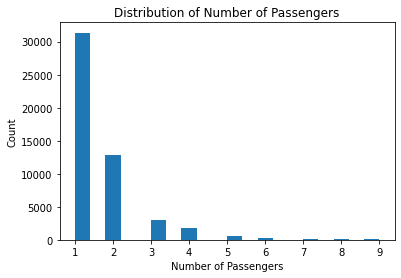

In [10]:
# Now, let's plot the distribution of the number of passengers
plt.hist(df['num_passengers'], bins=20)
plt.xlabel('Number of Passengers')
plt.ylabel('Count')
plt.title('Distribution of Number of Passengers')
plt.show()

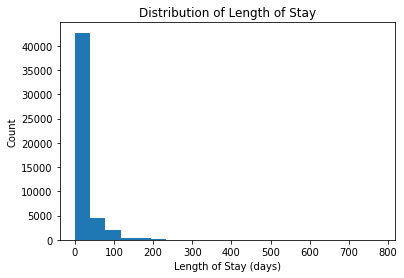

In [11]:
# Let's also plot the distribution of the length of stay
plt.hist(df['length_of_stay'], bins=20)
plt.xlabel('Length of Stay (days)')
plt.ylabel('Count')
plt.title('Distribution of Length of Stay')
plt.show()

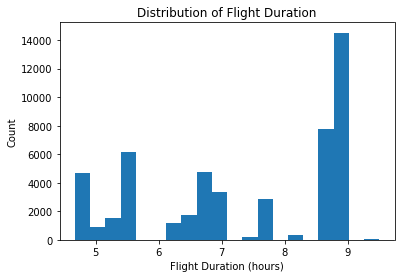

In [12]:
# Finally, let's plot the distribution of the flight duration
plt.hist(df['flight_duration'], bins=20)
plt.xlabel('Flight Duration (hours)')
plt.ylabel('Count')
plt.title('Distribution of Flight Duration')
plt.show()

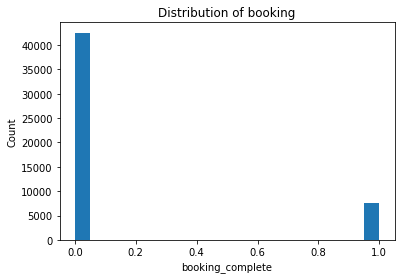

In [13]:
# Now, let's plot the distribution of the booking_complete
plt.hist(df['booking_complete'], bins=20)
plt.xlabel('booking_complete')
plt.ylabel('Count')
plt.title('Distribution of booking')
plt.show()

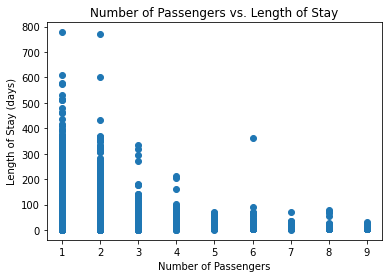

In [14]:
# Now, let's create a scatter plot of the number of passengers vs. the length of stay
plt.scatter(df['num_passengers'], df['length_of_stay'])
plt.xlabel('Number of Passengers')
plt.ylabel('Length of Stay (days)')
plt.title('Number of Passengers vs. Length of Stay')
plt.show()

In [15]:
# select relevant columns and drop missing values
data = df[['purchase_lead', 'length_of_stay', 'flight_duration', 'num_passengers']]
data = data.dropna()

# standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# perform PCA
pca = PCA()
pca.fit(data_scaled)

# view the explained variance ratio
print(pca.explained_variance_ratio_)

# view the principal components
print(pca.components_)

[0.32390786 0.27728177 0.21165626 0.18715411]
[[-0.52718781  0.50659964  0.25602759 -0.63236041]
 [ 0.52377225  0.39460402  0.73399402  0.17664393]
 [-0.06789478  0.7481618  -0.46621229  0.4672155 ]
 [-0.66567706 -0.16702814  0.42231357  0.59213758]]


In [23]:
# We need to select the features that we will use to train the model
# In this case, we will use all the columns except the 'booking_complete' column
X = df.drop(columns=['booking_complete'])

# The target variable is the 'booking_complete' column
y = df['booking_complete']

# Convert the specified columns to dummy variables
X = pd.get_dummies(X, columns=['sales_channel', 'trip_type', 'flight_hour', 'flight_day', 'route', 'booking_origin'])

# We will split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create the random over-sampler
ros = RandomOverSampler(sampling_strategy={1: 34002}, random_state=42)

# Oversample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


# Now we can create the random forest model and fit it to the training data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = model.predict(X_test)

In [24]:
# Use cross-validation to evaluate the model
scores = cross_val_score(model, X, y, cv=5)

# Print the accuracy, precision, recall, and F1 score
print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")

Accuracy: 0.74 (+/- 0.21)
Precision: 0.47
Recall: 0.25
F1 Score: 0.33


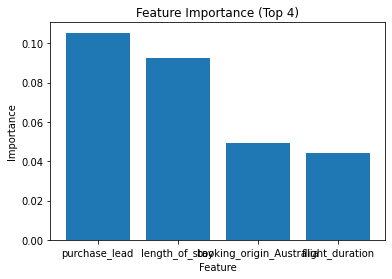

In [25]:
# Get the feature importance scores
importances = model.feature_importances_

# Get the feature names
feature_names = X.columns

# Create a sorted list of the feature importance scores and feature names
sorted_importances = sorted(zip(importances, feature_names), reverse=True)

# Extract the top 10 most important features
top_n = 4
top_importances = sorted_importances[:top_n]

# Create a bar plot of the top 4 most important features
plt.bar([x[1] for x in top_importances], [x[0] for x in top_importances])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance (Top 4)")
plt.show()